# 1D and 2D sparse grid-based interpolant plotter

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

 ### Helper functions

In [2]:
def replicate(elem, n):
    """Creates n-sized array filled with elem"""
    return [elem for i in range(0, n)]

def blend(*arrs):
    """Fuses arrays together, taking elements alternatively from each array in the arguments"""
    ret = []
    dim = len(arrs)
    pos = replicate(0, dim)
    lens = [len(arr) for arr in arrs]
    cont = True
    while cont:
        cont = False
        for i in range(0, dim):
            if pos[i] < lens[i]:
                ret.append(arrs[i][pos[i]])
                pos[i] += 1
                cont = True
    return ret

def concat(arrs):
    """Flattens array of arrays to one array"""
    ret = []
    for arr in arrs:
        for elem in arr:
            ret.append(elem)
    return ret

def take_cycle(arr, n):
    """Creates n-sized array of elements taken from arr cyclically"""
    return [arr[i % len(arr)] for i in range(0, n)]

def recursive_max(arr):
    """Finds maximum element in nested array"""
    acc = []
    for elem in arr:
        if isinstance(elem, list):
            acc.append(recursive_max(elem))
        else:
            acc.append(elem)
    return max(acc) if len(acc) > 0 else float("nan")

def recursive_min(arr):
    """Finds minimum element in nested array"""
    acc = []
    for elem in arr:
        if isinstance(elem, list):
            acc.append(recursive_min(elem))
        else:
            acc.append(elem)
    return min(acc) if len(acc) > 0 else float("nan")

def unique(arr):
    """Removes duplicate elements from array"""
    return list(set(arr))

def unzip(arr):
    """Unzips array of 2-tuples into two separate arrays"""
    (arr_1, arr_2) = ([], [])
    for (x, y) in arr:
        arr_1.append(x)
        arr_2.append(y)
    return arr_1, arr_2

### Standard hat basis functions

In [3]:
def hat_func(x):
    """Standard hat function"""
    return max(0.0, 1.0 - abs(x))

def _1d_hat_func(l, i, x):
    """Standard hat basis function associated with grid point i on sublevel l"""
    return hat_func(pow(2.0, l) * x - float(i))

def _1d_modified_hat_func(l, i, x):
    """Modified hat basis function associated with grid point i on sublevel l"""
    if l == 1 and i == 1:
        return 1.0
    elif l > 1 and i == 1:
        if x >= 0 and x <= (1.0 / pow(2.0, l-1)):
            return 2.0-pow(2.0, l) * x
        else:
            return 0.0
    elif l > 1 and i == 2**l - 1:
        if x >= (1.0 - 1.0 / pow(2.0, l-1)) and x <= 1.0:
            return pow(2.0, l) * x + 1.0 - float(i)
        else:
            return 0.0
    else:
        return _1d_hat_func(l, i, x)

### B-spline basis functions

In [4]:
def cox_de_boor_b_spline(g, x):
    """Recursive Cox-de Boor evaluation of B-splines"""
    if g == 0:
        return 1.0 if x >= 0 and x < 1 else 0.0
    else:
        g_f = float(g)
        return (x / g_f) * cox_de_boor_b_spline(g-1, x) + ((g_f+1.0-x) / g_f) * cox_de_boor_b_spline(g-1, x-1.0)

def _1d_b_spline_func(l, i, g, x):
    """B-spline basis function of degree g associated with grid point i on sublevel l"""
    return cox_de_boor_b_spline(g, pow(2.0, l) * x + ((float(g)+1.0) / 2) - float(i))

def _1d_cardinal_b_spline_func(l, i, x):
    """
    Cardinal B-spline basis function associated with grid point i on sublevel l
    The l parameter is kept for function signature compatibility
    """
    return cox_de_boor_b_spline(i-1, x)

def _1d_modified_b_spline_psi(l, g, x):
    """Psi helper function to evaluate modified B-splines of degree g on sublevel l"""
    ret = 0.0
    for k in range(0, math.ceil((g+1)/2) + 1):
        ret += float(k + 1) * _1d_b_spline_func(l, 1-k, g, x)
    return ret

def _1d_modified_b_spline_func(l, i, g, x):
    """Modified B-spline basis function of degree g associated with grid point i on sublevel l"""
    if l == 1 and i == 1:
        return 1.0
    elif l > 1 and i == 1:
        return _1d_modified_b_spline_psi(l, g, x)
    elif l > 1 and i == 2 ** l - 1:
        return _1d_modified_b_spline_psi(l, g, 1.0-x)
    else:
        return _1d_b_spline_func(l, i, g, x)

### Polynomial basis functions

In [5]:
def point_ancestor_hierarchy(l, i):
    """Constructs a point's ancestor hierarchy of grid point i on level l"""
    # Always include both boundary points
    if l == 0 and i == 0:
        return [(0, 0), (0, 1)]
    elif l == 0 and i == 1:
        return [(0, 1), (0, 0)]
    else:
        go_up_left = ((i+1) / 2) % 2 == 0
        return [(l, i)] + point_ancestor_hierarchy(l-1, int((i-1) / 2 if go_up_left else (i+1) / 2))

def _1d_polynomial_func(l, i, g, x):
    """Polynomial basis function of degree g associated with grid point i on sublevel l"""
    # Restrict support:
    if x < pow(2.0, -l) * float(i-1) or x > pow(2.0, -l) * float(i+1):
        return 0.0
    ancestors = point_ancestor_hierarchy(l, i)[1:g+2] # Exclude self; respect degree
    prod = 1.0
    own_knot_point_x = pow(2.0, -l) * i
    for (l_, i_) in ancestors:
        other_knot_point_x = pow(2.0, -l_) * i_
        prod *= (x - other_knot_point_x) / (own_knot_point_x - other_knot_point_x)
    return prod

### Plotting linear bases (e.g. hat functions)

In [6]:
def basis_xss_yfs(n, step, original_func, coeff=None, filter_nonzero=False):
    """
    Returns an array of arrays of X coordinates and an array of functions to evaluate at
    these coordinates to construct any univariate piecewise linear basis of mesh width 2^(-n)
    """
    (xss, yfs) = ([], [])
    coeff_pos = 0
    h_n = pow(2.0, -n)
    for i in range(1, 2**n, step):
        xs = np.arange(h_n * (i - 1), h_n * (i + 2), h_n)
        c = 1.0 if coeff is None else coeff[coeff_pos]
        yf = lambda x, c_2=c, i_2=i, n_2=n: c_2 * original_func(n_2, i_2, x)
        if filter_nonzero:
            xs = list(filter(lambda x, yf_2=yf: abs(yf_2(x)) > 0.0, xs))
        xss.append(xs)
        yfs.append(yf)
        coeff_pos += 1
    return xss, yfs

def nodal_basis_xss_yfs(n, coeff=None):
    """
    Returns an array of arrays of X coordinates and an array of functions to evaluate at
    these coordinates to construct the univariate standard hat function basis of level n 
    """
    return basis_xss_yfs(n, step=1, original_func=_1d_hat_func, coeff=coeff)

def nodal_basis_css_zfs(n, step, original_func=_1d_hat_func, coeff=None, filter_nonzero=False, delta=0.01):
    """
    Returns an array of arrays of (X, Y) coordinates and an array of functions to evaluate
    at these coordinates to construct any 2-dimensional piecewise linear basis of mesh width 2^(-n)
    """
    (css, zfs) = ([], [])
    (coeff_pos_i, coeff_pos_j) = (0, 0)
    h_n = pow(2.0, -n)
    for i in range(1, 2**n, step):
        for j in range(1, 2**n, step):
            xs = np.arange(h_n * (i - 1), h_n * (i + 1) + delta, delta)
            ys = np.arange(h_n * (j - 1), h_n * (j + 1) + delta, delta)
            c = 1.0 if coeff is None else coeff[coeff_pos_i][coeff_pos_j]
            zf = lambda coords, c_2=c, i_2=i, j_2=j, n_2=n: c_2 * original_func(n_2, i_2, coords[0]) * original_func(n_2, j_2, coords[1])
            cs = concat([[(x, y) for x in xs] for y in ys])
            if filter_nonzero:
                # Needed to keep enough points
                cs = list(filter(lambda coords, zf_2=zf, h_n_2=h_n: abs(zf_2(coords)) > 0.0
                                                                    or abs(zf_2((coords[0] + h_n_2, coords[1]))) > 0.0
                                                                    or abs(zf_2((coords[0] - h_n_2, coords[1]))) > 0.0
                                                                    or abs(zf_2((coords[0], coords[1] + h_n_2))) > 0.0
                                                                    or abs(zf_2((coords[0], coords[1] - h_n_2))) > 0.0
                                 , cs))
            css.append(cs)
            zfs.append(zf)
            coeff_pos_j += 1
        coeff_pos_i += 1
        coeff_pos_j = 0
    return css, zfs

### Plotting non-linear bases (e.g. B-splines)

In [7]:
def apply_yfs(xss, yfs):
    """
    Evaluates functions in yfs at the coordinates in xss and returns an
    array of arrays of function values
    """
    return [[(yfs[j])(xss[j][i]) for i in range(0, len(xss[j]))] for j in range(0, len(yfs))]

def apply_zfs(css, zfs):
    """2-dimensional version of apply_yfs"""
    return apply_yfs(css, zfs)

def sum_yfs(xss, yfs):
    """Returns an array of coordinates and an array of interpolant values at these coordinates"""
    xs = sorted(unique(concat(xss)))
    return xs, [sum([(yfs[j])(xs[i]) for j in range(0, len(yfs))]) for i in range(0, len(xs))]

def sum_zfs(css, zfs):
    """2-dimensional version of sum_yfs"""
    return sum_yfs(css, zfs)

def nonlinear_basis_xss_yfs(n, step, original_func, coeff=None, filter_nonzero=False, delta=0.0001, boundary_from=0.0, boundary_to=1.0, linear_limit=False):
    """
    Returns an array of arrays of X coordinates and an array of functions to evaluate at these
    coordinates to construct any (not necessary linear) basis of level n
    The step argument determines the step of the grid points (use 1 for nodal, 2 for hierarchical bases)
    If coeff is present, the basis functions are multiplied by the coefficients found there
    delta determines the point density
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    (xss, yfs) = ([], [])
    coeff_pos = 0
    for i in range(1, (n + 1) if linear_limit else 2**n, step):
        xs = np.arange(boundary_from, boundary_to, delta)
        c = 1.0 if coeff is None else coeff[coeff_pos]

        yf = lambda x, c_2=c, i_2=i, n_2=n: c_2 * original_func(n_2, i_2, x)
        if filter_nonzero:
            xs = list(filter(lambda x, yf_2=yf: abs(yf_2(x)) > 0.0, xs))

        xss.append(xs)
        yfs.append(yf)
        coeff_pos += 1
    return xss, yfs

### Convenience functions for construction of point sets

In [8]:
def hierarchical_basis_xss_yfs(l, coeff=None, filter_nonzero=False):
    """
    Applies basis_xss_yfs to a hierarchical standard hat function basis, to construct the sublevel l
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    """
    return basis_xss_yfs(l,
                         step=2,
                         original_func=_1d_hat_func,
                         coeff=coeff,
                         filter_nonzero=filter_nonzero)

def full_hierarchical_basis_xss_yfs(n, coeff=None, original_func=hierarchical_basis_xss_yfs, filter_nonzero=False):
    """
    Iterates through all sublevels and calls original_func (hierarchical_basis_xss_yfs) on each sublevel to construct
    a full hierarchical basis of level n
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    """
    ret_xss, ret_yfs = ([], [])
    for l in range(1, n+1):
        xss, yfs = original_func(l, coeff=(None if coeff is None else coeff[l-1]), filter_nonzero=filter_nonzero)
        ret_xss += xss
        ret_yfs += yfs
    return ret_xss, ret_yfs

def full_hierarchical_basis_css_zfs(n, step, original_func=nodal_basis_css_zfs, coeff=None, filter_nonzero=False):
    """
    2-dimensional version of full_hierarchical_basis_xss_yfs
    """
    return full_hierarchical_basis_xss_yfs(n,
                                           coeff=coeff,
                                           original_func=(lambda l, coeff, filter_nonzero, step_2=step, func=original_func: func(l, step=step_2, coeff=coeff, filter_nonzero=filter_nonzero, delta=0.005)),
                                           filter_nonzero=filter_nonzero)

def modified_nodal_basis_xss_yfs(n, coeff=None, filter_nonzero=False):
    """
    Returns coordinates and functions to evaluate at these coordinates to construct a modified nodal hat function
    basis of level n
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return basis_xss_yfs(n,
                         step=1,
                         original_func=_1d_modified_hat_func,
                         coeff=coeff,
                         filter_nonzero=filter_nonzero)

def hierarchical_polynomial_basis_xss_yfs(n, degree=3, coeff=None, filter_nonzero=True):
    """
    Returns coordinates and functions to evaluate at these coordinates to construct a hierarchical
    piecewise polynomial basis of level n
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return nonlinear_basis_xss_yfs(n,
                                  step=2,
                                  original_func=(lambda l, i, x, g=degree: _1d_polynomial_func(l, i, g, x)),
                                  coeff=coeff,
                                  filter_nonzero=filter_nonzero)

def hierarchical_b_spline_basis_xss_yfs(n, degree=3, coeff=None, filter_nonzero=False):
    """
    Returns coordinates and functions to evaluate at these coordinates to construct a hierarchical
    piecewise polynomial basis of level n
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return nonlinear_basis_xss_yfs(n,
                                  step=2,
                                  original_func=(lambda l, i, x, g=degree: _1d_b_spline_func(l, i, g, x)),
                                  coeff=coeff,
                                  filter_nonzero=filter_nonzero)

def modified_hierarchical_basis_xss_yfs(l, coeff=None, filter_nonzero=False):
    """
    Returns coordinates and functions to evaluate at these coordinates to construct the sublevel l of
    a modified hierarchical hat function basis
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return basis_xss_yfs(l,
                         step=2,
                         original_func=_1d_modified_hat_func,
                         coeff=coeff,
                         filter_nonzero=filter_nonzero)

def modified_full_hierarchical_basis_xss_yfs(n, coeff=None, filter_nonzero=False):
    """
    Uses full_hierarchical_basis_xss_yfs to construct a full hierarchical basis of level n
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return full_hierarchical_basis_xss_yfs(n,
                                           coeff=coeff,
                                           original_func=modified_hierarchical_basis_xss_yfs,
                                           filter_nonzero=filter_nonzero)

def modified_hierarchical_b_spline_basis_xss_yfs(l, degree=3, coeff=None, filter_nonzero=False):
    """
    Returns coordinates and functions to evaluate at these coordinates to construct the sublevel l of
    a modified hierarchical B-spline basis of the specified degree
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return nonlinear_basis_xss_yfs(l,
                                   step=2,
                                   original_func=(lambda l, i, x, g=degree: _1d_modified_b_spline_func(l, i, g, x)),
                                   coeff=coeff,
                                   filter_nonzero=filter_nonzero)

def cardinal_b_splines_xss_yfs(n, coeff=None, filter_nonzero=False):
    """
    Returns coordinates and functions to evaluate at these coordinates to get a set of points representing the cardinal
    B-splines of degrees [0, n-1]
    If coeff is provided, the basis functions are multiplied by the coefficients therein
    If filter_nonzero is set, only points lying within a basis function's support are considered
    """
    return nonlinear_basis_xss_yfs(n,
                                   step=1,
                                   original_func=_1d_cardinal_b_spline_func,
                                   coeff=coeff,
                                   filter_nonzero=filter_nonzero,
                                   delta=0.001,
                                   boundary_to=float(n),
                                   linear_limit=True)

### Tick and tick label helper functions (for univariate bases)

In [9]:
# Note: only applicable to univariate bases

def basis_ticks_embed_outer(ticks, include_outer):
    """Adds boundary points to ticks if include_outer is set"""
    return ([0.0] if include_outer else []) + ticks + ([1.0] if include_outer else [])

def basis_ticklabels_embed_outer(ticklabels, include_outer, fill_outer):
    """
    Adds boundary labels to tick labels if include_outer is set
    Will only add actual text if fill_outer is set
    """
    return (["0.0" if fill_outer else ""] if include_outer else []) + ticklabels + (["1.0" if fill_outer else ""] if include_outer else [])

def basis_ticks(l, step, include_outer):
    """
    Returns ticks of a basis of level l, using the given step (use 1 for nodal bases, 2 for hierarchical bases)
    Will include boundary points if include_outer is set
    """
    return basis_ticks_embed_outer([i * pow(2.0, -l) for i in range(1, pow(2, l), step)], include_outer)

def nodal_basis_ticks(n, include_outer=False):
    """Convenience function; forwards arguments to basis_ticks with step=1"""
    return basis_ticks(n, 1, include_outer)

def hierarchical_basis_ticks(l, include_outer=False):
    """
    Convenience function; forwards arguments to basis_ticks with step=2
    Used to get the ticks of sublevel l of a hierarchical basis
    """
    return basis_ticks(l, 2, include_outer)

def full_hierarchical_basis_ticks(n, include_outer=False):
    """
    Returns ticks for a full hierarchical basis of level n
    Will include boundary points if include_outer is set
    """
    return basis_ticks_embed_outer(concat([hierarchical_basis_ticks(l, include_outer=False) for l in range(1, n+1)]), include_outer)

def no_ticks(n, include_outer):
    """Function used to disable ticks"""
    return []

def no_ticklabels(n, step, include_outer=True, fill_outer=False):
    """Function used to disable tick labels"""
    return []

def basis_ticklabels(l, step, include_outer=True, fill_outer=False):
    """Constructs tick labels of a basis of level l, using the given step (use 1 for nodal bases, 2 for hierarchical bases)"""
    return basis_ticklabels_embed_outer(["$x_{" + str(l) + "," + str(i) + "}$" for i in range(1, pow(2, l), step)], include_outer, fill_outer)

def full_hierarchical_basis_ticklabels(n, include_outer=True, fill_outer=False):
    """
    Returns tick labels for a full hierarchical basis of level n
    Will include boundary labels if include_outer is set
    Will only add actual text to boundary labels if fill_outer is set
    """
    return basis_ticklabels_embed_outer(concat([basis_ticklabels(l, 2, include_outer=False) for l in range(0, n+1)]), include_outer, fill_outer)

### Actual basis plotting

In [10]:
def plot_basis(n, colors, basis_xss_yfs_func, tick_func, label_func, step, coeff=None, interpolant_color=None, dpi=100, boundary_from=0.0, boundary_to=1.0):
    """
    Plots the basis of level n, using a cycle of the specified colors for the basis functions
    basis_xss_yfs_func should return an array of arrays of X coordinates, and an array of functions
    to evaluate at these coordinates in order to construct the basis
    tick_func and label_func are used to get the ticks and tick labels
    step determines the grid point step (use 1 for nodal, 2 for hierarchical bases)
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using a bold line of color interpolant_color
    dpi determines the DPI and thus the resolution of the resulting image
    boundary_from and boundary_to determine the xlim of the resulting image
    """
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(111)
    xss, yfs = basis_xss_yfs_func(n, coeff)
    yss = apply_yfs(xss, yfs)
    do_interpolate = interpolant_color is not None and coeff is not None
    colors_final = take_cycle(colors, len(yfs)) if len(colors) == 0 or not isinstance(colors[0], list) else concat(colors)
    interpolant_xs, interpolant_ys = sum_yfs(xss, yfs) if do_interpolate else (None, None)
    interpolant_params = [interpolant_xs, interpolant_ys, interpolant_color] if do_interpolate else []
    lines = plt.plot(*(blend(xss, yss, colors_final) + interpolant_params))
    if do_interpolate:
        plt.setp(lines[len(lines)-1], linewidth=3, color=interpolant_color)
    ax.set(xticks=tick_func(n, include_outer=True), yticks=[], xticklabels=label_func(n, step))
    ax.set_xlim(left=boundary_from, right=boundary_to)
    all_ys = concat(yss)
    btm = min(0.0, recursive_min(all_ys + (interpolant_ys if do_interpolate else [])))
    top = max(1.0, recursive_max(all_ys + (interpolant_ys if do_interpolate else [])))
    
    # Add some padding if plotted region gets too big vertically
    btm = pow(1.01, abs(btm)) * btm
    top = pow(1.01, abs(top)) * top
    
    ax.set_ylim(bottom=btm, top=top)
    ax.tick_params(width=1.5, length=6.0)
    ax.spines['bottom'].set_position('zero')
    for s in ["top", "left", "right"]:
        ax.spines[s].set_visible(False)
    plt.show()

def plot_2d_basis(n, colors, basis_css_zfs_func, step, coeff=None, alpha=0.85, interpolant_color=None, interpolant_alpha=None, filter_nonzero=False, show_grid=True, show_ticks=True, dpi=100):
    """
    Plots the 2-dimensional basis of level n, using a cycle of the specified colors for the basis functions
    basis_css_zfs_func should return an array of arrays of (X, Y) coordinates, and an array of functions
    to evaluate at these coordinates in order to construct the basis
    step determines the grid point step (use 1 for nodal, 2 for hierarchical bases)
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    alpha and interpolant_alpha determine the alpha values of the basis functions and the interpolant, respectively
    If filter_nonzero is set, only points lying within a basis function's support are considered
    dpi determines the DPI and thus the resolution of the resulting image
    If show_grid is set, grid lines are plotted
    If show_ticks is set, ticks are added to the axes
    """
    
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    css, zfs = basis_css_zfs_func(n=n, step=step, coeff=coeff, filter_nonzero=filter_nonzero)
    zss = apply_zfs(css, zfs)
    colors_final = take_cycle(colors, len(css)) if len(colors) == 0 or not isinstance(colors[0], list) else concat(colors)

    for i in range(0, len(css)):
        cs = css[i]
        xs, ys = unzip(cs)
        zs = zss[i]
        ax.plot_trisurf(xs, ys, zs, color=colors_final[i], alpha=alpha, antialiased=(alpha<1.0))

    if interpolant_color is not None:
        cs, zs = sum_zfs(css, zfs)
        xs, ys = unzip(cs)
        ax.plot_trisurf(xs, ys, zs, alpha=(alpha if interpolant_alpha is None else interpolant_alpha), color=interpolant_color)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")

    if not show_ticks:
        for t in [*ax.xaxis.get_major_ticks(), *ax.yaxis.get_major_ticks(), *ax.zaxis.get_major_ticks()]:
            t.set_visible(False)
            t.label1.set_visible(False)

    if not show_grid:
        ax.grid(False)

    plt.show()

### Convenience functions for plotting

In [11]:
DEFAULT_DPI = 100

def plot_nodal_basis(n, colors=["k"], coeff=None, interpolant_color=None, modified=False, label_func=basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots a nodal hat function basis of level n, using the given cycle of colors
    If modified is set, modified hat functions are used; standard hat functions are used otherwise
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(n,
                      colors,
                      basis_xss_yfs_func=(modified_nodal_basis_xss_yfs if modified else nodal_basis_xss_yfs),
                      tick_func=nodal_basis_ticks,
                      label_func=label_func,
                      step=1,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_hierarchical_basis(l, colors=["k"], coeff=None, interpolant_color=None, modified=False, label_func=basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots the sublevel l of a hierarchical hat function basis, using the given cycle of colors
    If modified is set, modified hat functions are used; standard hat functions are used otherwise
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(l,
                      colors,
                      basis_xss_yfs_func=(modified_hierarchical_basis_xss_yfs if modified else hierarchical_basis_xss_yfs),
                      tick_func=hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_full_hierarchical_basis(n, colors=["k"], coeff=None, interpolant_color=None, modified=False, label_func=full_hierarchical_basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots the hierarchical hat function basis of level n, using the given cycle of colors
    If modified is set, modified hat functions are used; standard hat functions are used otherwise
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(n,
                      colors,
                      basis_xss_yfs_func=(modified_full_hierarchical_basis_xss_yfs if modified else full_hierarchical_basis_xss_yfs),
                      tick_func=full_hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_hierarchical_b_spline_basis(l, colors=["k"], coeff=None, interpolant_color=None, modified=False, degree=3, label_func=basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots the sublevel l of a hierarchical B-spline basis, using the given cycle of colors and B-splines of the given degree
    If modified is set, modified B-splines are used
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(l,
                      colors,
                      basis_xss_yfs_func=(lambda n, coeff, g=degree, modified2=modified: (modified_hierarchical_b_spline_basis_xss_yfs if modified2 else hierarchical_b_spline_basis_xss_yfs)(n, g, coeff)),
                      tick_func=hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_full_hierarchical_b_spline_basis(n, colors=["k"], coeff=None, interpolant_color=None, modified=False, degree=3, label_func=full_hierarchical_basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots the hierarchical B-spline basis of level n, using the given cycle of colors and B-splines of the given degree
    If modified is set, modified B-splines are used
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(n,
                      colors,
                      basis_xss_yfs_func=lambda n, coeff, g=degree, modified2=modified: full_hierarchical_basis_xss_yfs(n, coeff, (lambda n, coeff, filter_nonzero, g2=g, modified3=modified2: (modified_hierarchical_b_spline_basis_xss_yfs if modified3 else hierarchical_b_spline_basis_xss_yfs)(n, degree=g2, coeff=coeff, filter_nonzero=filter_nonzero))),
                      tick_func=full_hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_hierarchical_polynomial_basis(l, colors=["k"], coeff=None, interpolant_color=None, degree=3, label_func=basis_ticklabels, dpi=DEFAULT_DPI):
    """
    Plots the sublevel l of a hierarchical polynomial basis, using the given cycle of colors and piecewise polynomials
    of the given degree
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(l,
                      colors,
                      basis_xss_yfs_func=(lambda n, coeff, g=degree: hierarchical_polynomial_basis_xss_yfs(n, g, coeff)),
                      tick_func=hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_full_hierarchical_polynomial_basis(n, colors=["k"], coeff=None, interpolant_color=None, degree=3, label_func=full_hierarchical_basis_ticklabels, filter_nonzero=False, dpi=DEFAULT_DPI):
    """
    Plots the hierarchical polynomial basis of level n, using the given cycle of colors and piecewise polynomials of the given degree
    If coeff and interpolant_color are set, the basis functions are multiplied by the coefficients found in coeff,
    and an interpolant is formed from their sum, plotted using the color interpolant_color
    label_func is used to get the tick labels
    dpi determines the DPI and thus the resolution of the resulting image
    """
    return plot_basis(n,
                      colors,
                      basis_xss_yfs_func=lambda n, coeff, g=degree, filter_nonzero_2=filter_nonzero: full_hierarchical_basis_xss_yfs(n, coeff, filter_nonzero=filter_nonzero_2, original_func=(lambda n, coeff, filter_nonzero, g2=g: hierarchical_polynomial_basis_xss_yfs(n, g2, coeff, filter_nonzero=filter_nonzero))),
                      tick_func=full_hierarchical_basis_ticks,
                      label_func=label_func,
                      step=2,
                      coeff=coeff,
                      interpolant_color=interpolant_color,
                      dpi=dpi)

def plot_cardinal_b_splines(n, colors=["k"], dpi=DEFAULT_DPI):
    """
    Plots the cardinal B-splines of degrees [0,n-1] using the given cycle of colors
    dpi determines the DPI and thus the resolution of the resulting image
    """    
    return plot_basis(n,
                      colors,
                      basis_xss_yfs_func=lambda n, coeff: cardinal_b_splines_xss_yfs(n, coeff),
                      tick_func=no_ticks,
                      label_func=no_ticklabels,
                      step=1,
                      boundary_from=0.0,
                      boundary_to=n)

## Examples

### Nodal bases of levels 1, 2 and 3

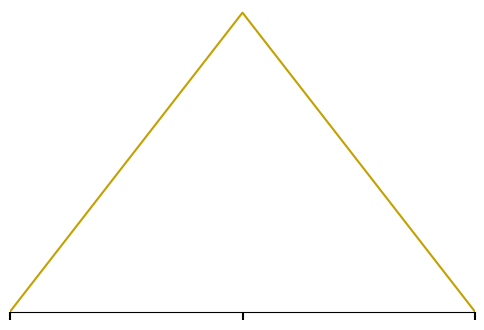

In [12]:
plot_nodal_basis(1, colors=["#C4A000"], label_func=no_ticklabels)

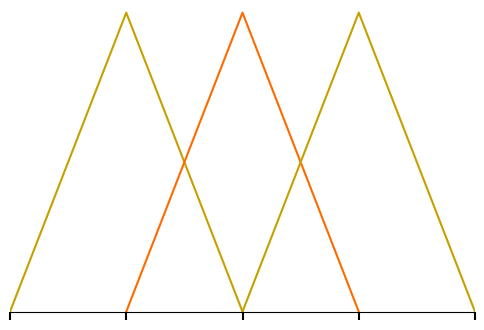

In [13]:
plot_nodal_basis(n=2, colors=["#C4A000", "#FF6A00"], label_func=no_ticklabels)

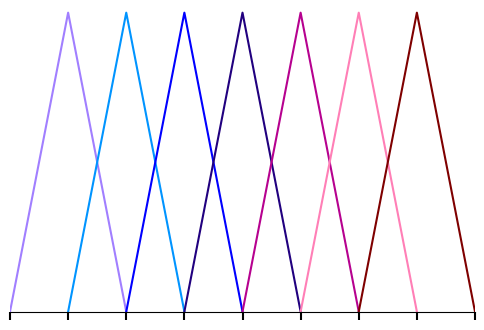

In [14]:
plot_nodal_basis(n=3, colors=["#A17FFF", "#0094FF", "#0000FF", "#21007F", "#B6018F", "#FF7FB6", "#7F0000"], label_func=no_ticklabels)

### An interpolant generated by the nodal hat function basis of n=3

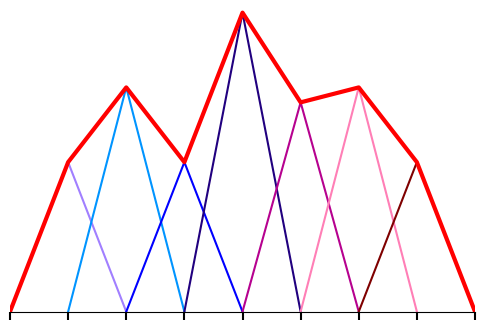

In [15]:
plot_nodal_basis(n=3,
                colors=["#A17FFF", "#0094FF", "#0000FF", "#21007F", "#B6018F", "#FF7FB6", "#7F0000"],
                label_func=no_ticklabels,
                coeff=[0.5, 0.75, 0.5, 1.0, 0.7, 0.75, 0.5],
                interpolant_color="r")

### Omitting grid points in nodal basis causes gaps in interpolant

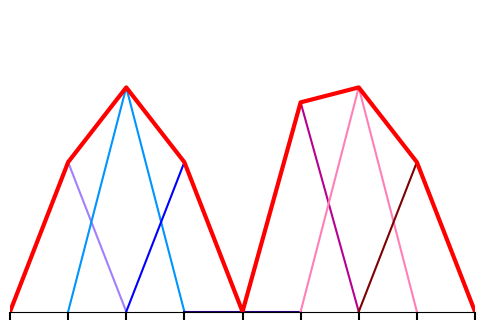

In [16]:
plot_nodal_basis(n=3,
                colors=["#A17FFF", "#0094FF", "#0000FF", "#21007F", "#B6018F", "#FF7FB6", "#7F0000"],
                label_func=no_ticklabels,
                coeff=[0.5, 0.75, 0.5, 0.0, 0.7, 0.75, 0.5],
                interpolant_color="r")

### The solution: hierarchical bases...

### ...first of level 1

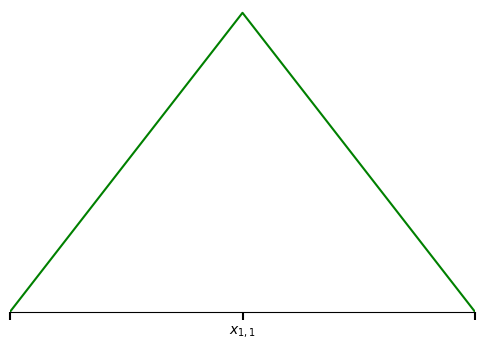

In [17]:
plot_full_hierarchical_basis(n=1, colors=["g"])

### ...now of level 2, with the sublevels plotted first and then the whole basis

Note that when using hierarchical bases, grid points with even indices are omitted

#### Sublevel 1 (just as above)

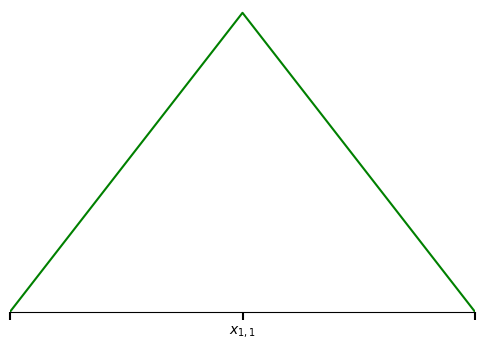

In [18]:
plot_hierarchical_basis(l=1, colors=["g"])

#### Sublevel 2

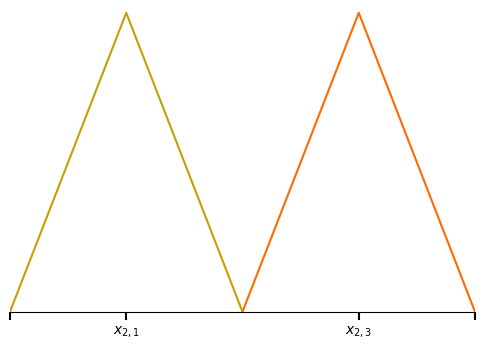

In [19]:
plot_hierarchical_basis(l=2, colors=["#C4A000", "#FF6A00"])

#### Sublevel 3

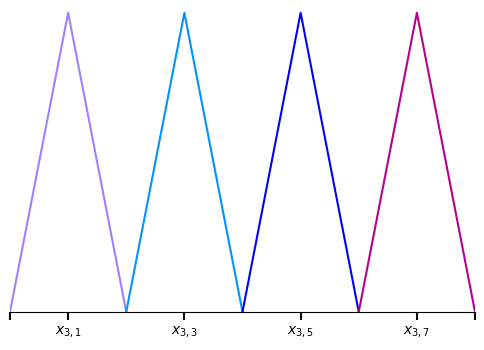

In [20]:
plot_hierarchical_basis(l=3, colors=["#A17FFF", "#0094FF", "b", "#B6018F"])

#### And the whole basis

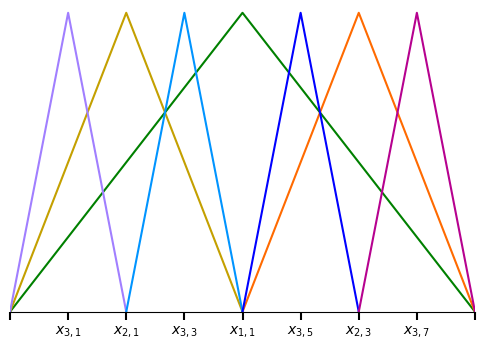

In [21]:
plot_full_hierarchical_basis(n=3,
                             colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]])

### Modified bases allow us to create interpolants with non-zero boundary values

#### Let's look at a modified hierarchical hat function basis of level 3

#### Sublevel 1: A constant function

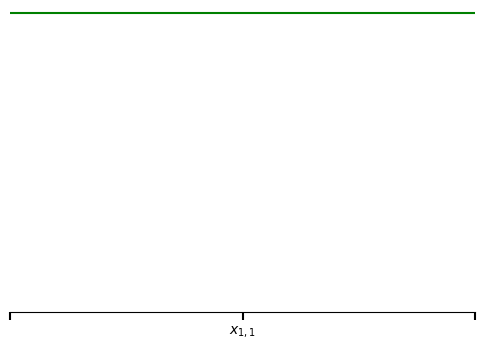

In [22]:
plot_hierarchical_basis(l=1,
                        colors=["g"],
                        modified=True)

#### Sublevel 2: from this sublevel on, the outermost basis functions are linearly extrapolated towards the boundary

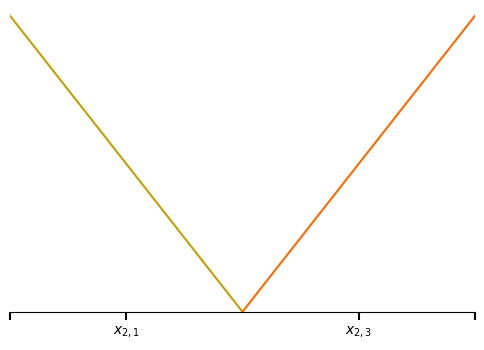

In [23]:
plot_hierarchical_basis(l=2,
                        colors=["#C4A000", "#FF6A00"],
                        modified=True)

#### Sublevel 3: The non-extrapolated inner basis functions can be seen nicely

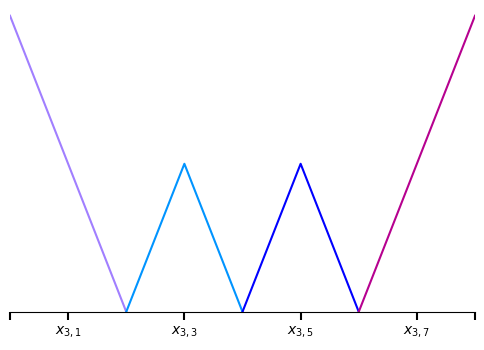

In [24]:
plot_hierarchical_basis(l=3,
                        colors=["#A17FFF", "#0094FF", "b", "#B6018F"],
                        modified=True)

#### Finally, the whole basis:

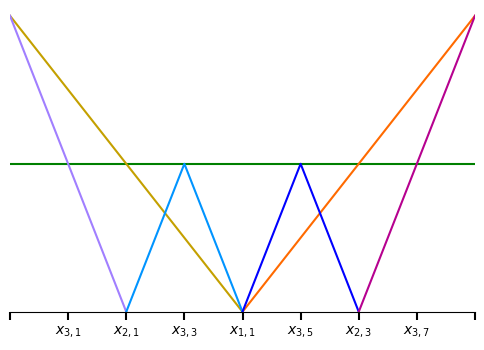

In [25]:
plot_full_hierarchical_basis(n=3, 
                             colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                             modified=True)

### Let's form some interpolants (bold red lines) using these bases:

Hint: play around with the coefficients and/or colors!

#### The standard hat function basis: 

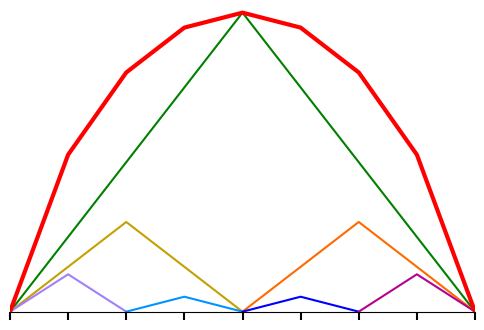

In [26]:
plot_full_hierarchical_basis(n=3,
                             colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                             coeff=[[1.0], [0.3, 0.3], [0.125, 0.05, 0.05, 0.125]], interpolant_color="r",
                             label_func=no_ticklabels)

#### The modified hat function basis (note the non-zero boundary values):

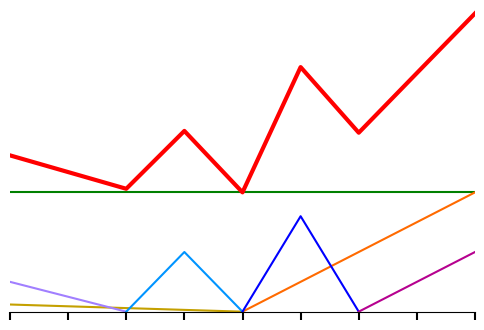

In [27]:
plot_full_hierarchical_basis(n=3,
                             colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                             coeff=[[0.5], [0.015, 0.25], [0.0625, 0.25, 0.4, 0.125]],
                             interpolant_color="r",
                             modified=True,
                             label_func=no_ticklabels)

### Let's look at the multivariate case: hierarchical basis of level 2

#### Plot the sublevels; first, sublevel 1:

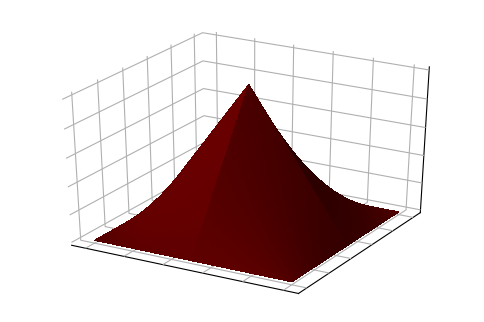

In [28]:
plot_2d_basis(n=1,
              colors=["#680000"],
              step=1,
              basis_css_zfs_func=nodal_basis_css_zfs,
              alpha=1.0,
              show_ticks=False)

#### Sublevel 2:

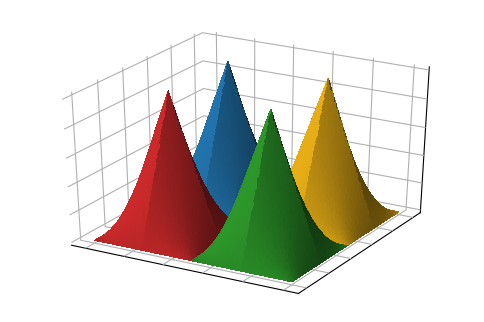

In [29]:
plot_2d_basis(n=2,
              colors=["#CC2A2B", "#2274AD", "#2D972A", "#E7AE16"],
              step=2,
              basis_css_zfs_func=nodal_basis_css_zfs,
              alpha=1.0,
              show_ticks=False)

#### The whole basis spanning an interpolant (cyan):

If you look closely, you can see the individual basis functions contributing to the interpolant

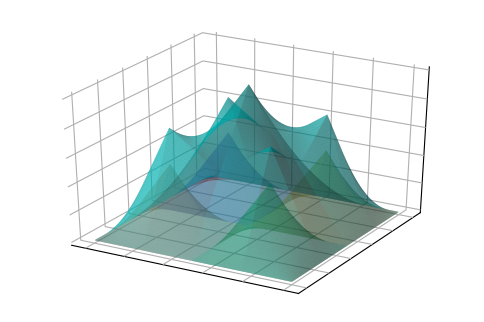

In [30]:
plot_2d_basis(n=2,
              colors=[["r"], ["#FF9244", "#0000FF", "g", "y"]],
              step=2,
              basis_css_zfs_func=full_hierarchical_basis_css_zfs,
              coeff=[[[1.0]], [[0.5, 0.5], [0.5, 0.5]]],
              alpha=0.25,
              interpolant_color="c",
              interpolant_alpha=0.5,
              filter_nonzero=True,
              show_ticks=False)

### Other basis functions: Piecewise polynomials

#### Polynomial basis of n=3 and polynomial degree 3, again with sublevels 1 to 3 first:

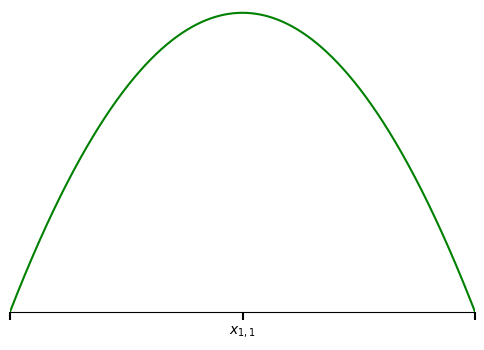

In [31]:
plot_hierarchical_polynomial_basis(l=1,
                                   colors=["#008000"],
                                   degree=3)

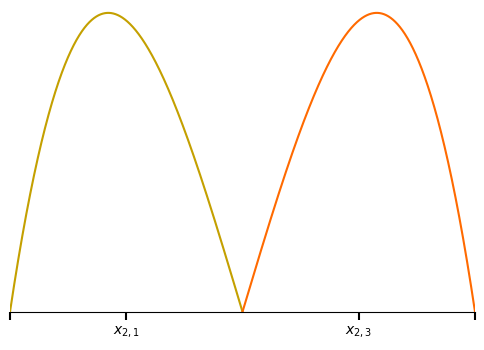

In [32]:
plot_hierarchical_polynomial_basis(l=2,
                                   colors=["#C4A000", "#FF6A00"],
                                   degree=3)

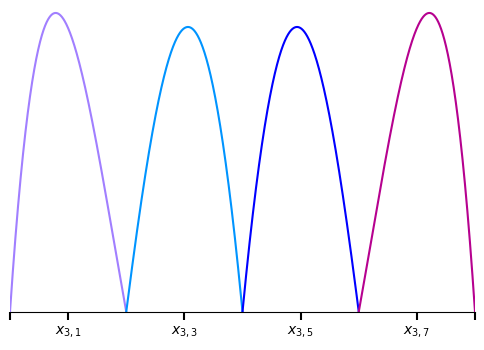

In [33]:
plot_hierarchical_polynomial_basis(l=3,
                                   colors=["#A17FFF", "#0094FF", "#0000FF", "#B6018F"],
                                   degree=3)

#### Collectively, these sublevels form the hierarchical piecewise polynomial basis of n=3:

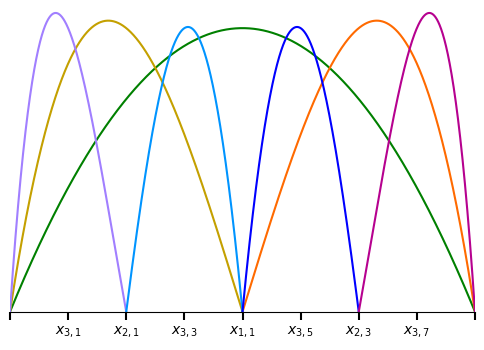

In [34]:
plot_full_hierarchical_polynomial_basis(n=3,
                                        colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                                        filter_nonzero=True, # paint only support of basis functions
                                        degree=3)

#### An interpolant constructed by this basis:

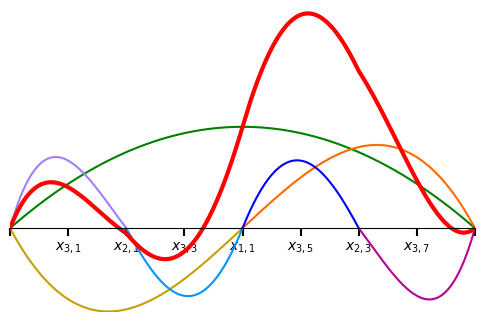

In [35]:
plot_full_hierarchical_polynomial_basis(n=3,
                                        colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                                        coeff=[[0.75], [-0.6, 0.6], [0.5, -0.5, 0.5, -0.5]], interpolant_color="r",
                                        filter_nonzero=True)

#### However, the interpolants constructed by a piecewise polynomial basis are not necessarily continuously differentiable:

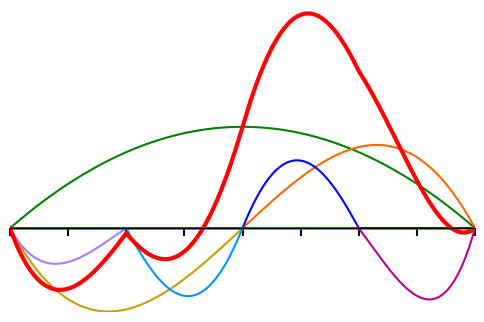

In [36]:
plot_full_hierarchical_polynomial_basis(n=3,
                                        colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                                        coeff=[[0.75], [-0.6, 0.6], [-0.25, -0.5, 0.5, -0.5]], interpolant_color="r",
                                        filter_nonzero=False,
                                        label_func=no_ticklabels)

### B-splines

#### A basis function type which yields continuously differentiable interpolants; B-spline basis functions are based on _cardinal B-splines:_

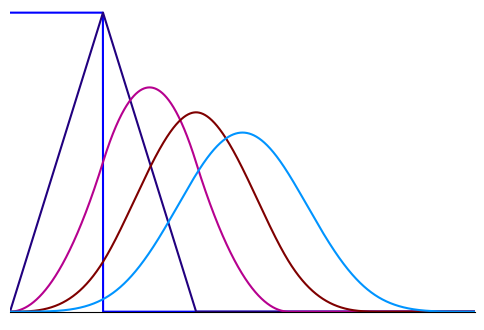

In [37]:
plot_cardinal_b_splines(n=5, # 0 to 4
                        colors=["#0000FF", "#21007F", "#B6018F", "#7F0000", "#0094FF", "#A17FFF"])

Cardinal B-splines of degree 0 to 4, from left to right.

#### Again, let's see the three sublevels of a basis of n=3 first:

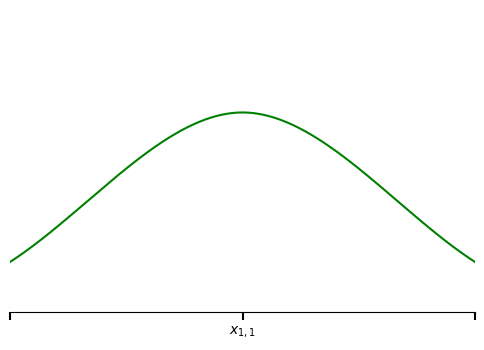

In [38]:
plot_hierarchical_b_spline_basis(l=1,
                                 colors=["#008000"])

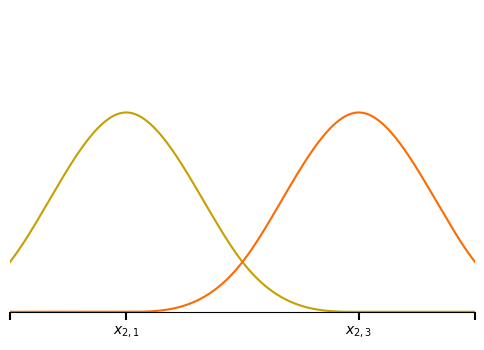

In [39]:
plot_hierarchical_b_spline_basis(l=2,
                                 colors=["#C4A000", "#FF6A00"])

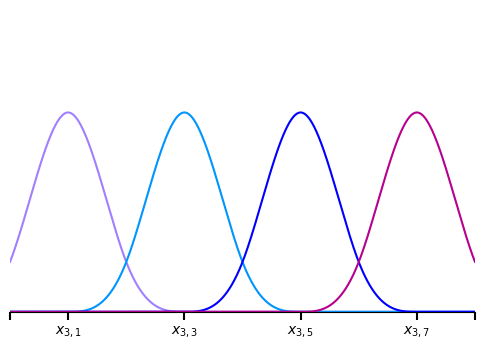

In [40]:
plot_hierarchical_b_spline_basis(l=3,
                                 colors=["#A17FFF", "#0094FF", "#0000FF", "#B6018F"],
                                 degree=3)

#### The full basis:

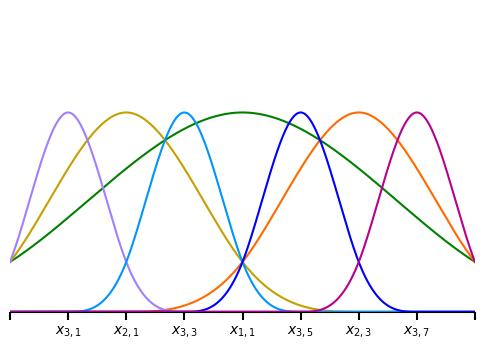

In [41]:
plot_full_hierarchical_b_spline_basis(n=3,
                                      colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"],
                                              ["#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0"]])

#### A B-spline-based interpolant (bold red line):

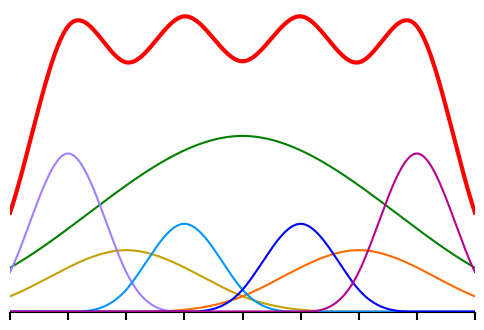

In [42]:
plot_full_hierarchical_b_spline_basis(n=3,
                                      coeff=[[2.0], [0.7, 0.7], [1.8, 1.0, 1.0, 1.8]],
                                      colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"]],
                                      interpolant_color="r",
                                      label_func=no_ticklabels)

#### A B-spline basis of n=4, but modified to allow for arbitrary boundary values:

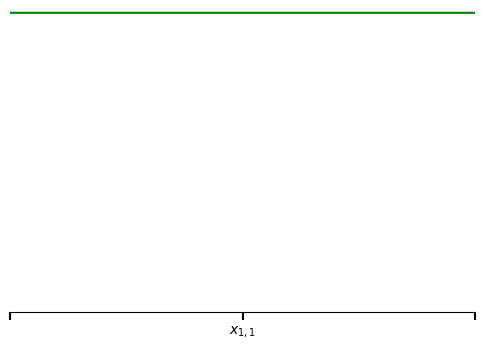

In [43]:
plot_hierarchical_b_spline_basis(l=1,
                                 colors=["#008000"],
                                 modified=True)

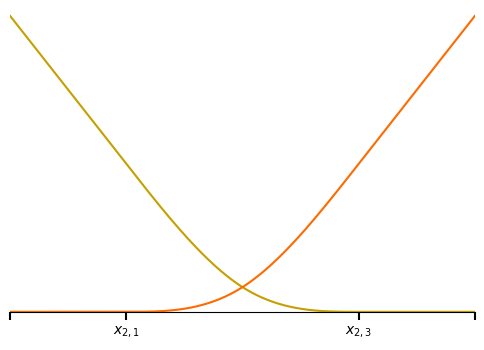

In [44]:
plot_hierarchical_b_spline_basis(l=2,
                                 colors=["#C4A000", "#FF6A00"],
                                 modified=True)

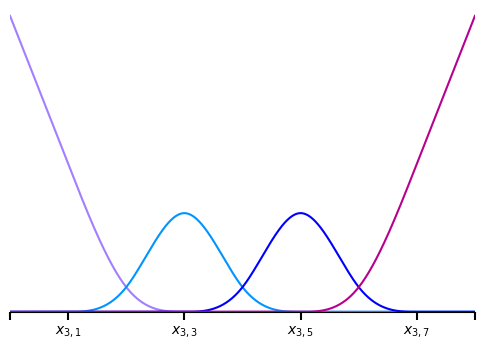

In [45]:
plot_hierarchical_b_spline_basis(l=3,
                                 colors=["#A17FFF", "#0094FF", "#0000FF", "#B6018F"],
                                 modified=True)

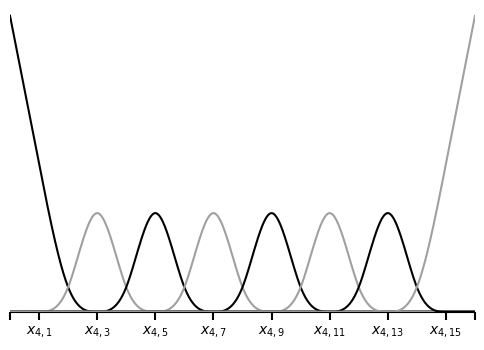

In [46]:
plot_hierarchical_b_spline_basis(l=4,
                                 colors=["k", "#a0a0a0"],
                                 modified=True)

#### Finally, let's see an interesting interpolant generated by this modified B-spline basis:

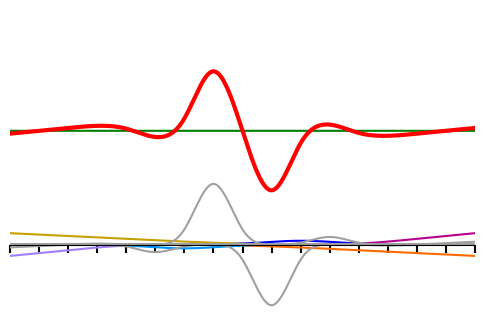

In [47]:
plot_full_hierarchical_b_spline_basis(n=4,
                                      coeff=[[20.0], [1.0, -1.0], [-1.0,-1.0,1.0,1.0],
                                               [-0.25, 0.25, -2.0, 16.0, -16.0, 2.0, -0.25, 0.25]],
                                      colors=[["g"], ["#C4A000", "#FF6A00"], ["#A17FFF", "#0094FF", "b", "#B6018F"],
                                             ["#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0", "#a0a0a0"]],
                                      interpolant_color="r",
                                      label_func=no_ticklabels,
                                      modified=True)